In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500.index = pd.to_datetime(sp500.index)
sp500

In [ ]:
sp500 = sp500.drop(columns=["Dividends", "Stock Splits"])
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.dropna(subset=["Tomorrow"])
sp500 = sp500.loc["1990-01-01":].copy()


In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def predict_with_prob(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, predict_func=predict, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_func(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [ ]:
base_predictors = ["Close", "Volume", "Open", "High", "Low"]
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

In [ ]:

for horizon in horizons:
    rolling_averages = sp500.rolling(window=horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(window=horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [ ]:
sp500 = sp500.dropna(subset=[col for col in sp500.columns if col != "Tomorrow"])
sp500

In [ ]:
base_model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
prob_model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)

In [ ]:
base_predictions = backtest(sp500, base_model, base_predictors)
print("Base Model (Original Prediction) Results:")
print("Predictions Value Counts:", base_predictions["Predictions"].value_counts())
print("Precision:", precision_score(base_predictions["Target"], base_predictions["Predictions"]))

In [ ]:
prob_predictions = backtest(sp500, prob_model, new_predictors, predict_func=predict_with_prob)
print("\nAdvanced Model (Probability Thresholding) Results:")
print("Predictions Value Counts:", prob_predictions["Predictions"].value_counts())
print("Precision:", precision_score(prob_predictions["Target"], prob_predictions["Predictions"]))

In [ ]:
print("\nBase Model Target Distribution:")
print(base_predictions["Target"].value_counts(normalize=True))
print("\nAdvanced Model Target Distribution:")
print(prob_predictions["Target"].value_counts(normalize=True))

In [ ]:
def plot_prediction_probabilities(model, predictors, data):
    model.fit(data[predictors], data['Target'])
    probs = model.predict_proba(data[predictors])[:,1]
    
    plt.figure(figsize=(10, 6))
    plt.hist(probs, bins=50, edgecolor='black')
    plt.title('Distribution of Prediction Probabilities')
    plt.xlabel('Probability of Positive Prediction')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_prediction_probabilities(base_model, base_predictors, sp500)
plot_prediction_probabilities(prob_model, new_predictors, sp500)

In [ ]:
from sklearn.metrics import precision_score, recall_score

def plot_model_performance(base_preds, prob_preds):
    models = ['Base Model', 'Probability Model']
    precisions = [
        precision_score(base_preds['Target'], base_preds['Predictions']),
        precision_score(prob_preds['Target'], prob_preds['Predictions'])
    ]
    recalls = [
        recall_score(base_preds['Target'], base_preds['Predictions']),
        recall_score(prob_preds['Target'], prob_preds['Predictions'])
    ]

    plt.figure(figsize=(10, 6))
    x = range(len(models))
    width = 0.35

    plt.bar([i - width/2 for i in x], precisions, width, label='Precision', color='blue')
    plt.bar([i + width/2 for i in x], recalls, width, label='Recall', color='green')

    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models)
    plt.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

plot_model_performance(base_predictions, prob_predictions)

Regression Model Results:
Mean Absolute Error: 113.55833051920122


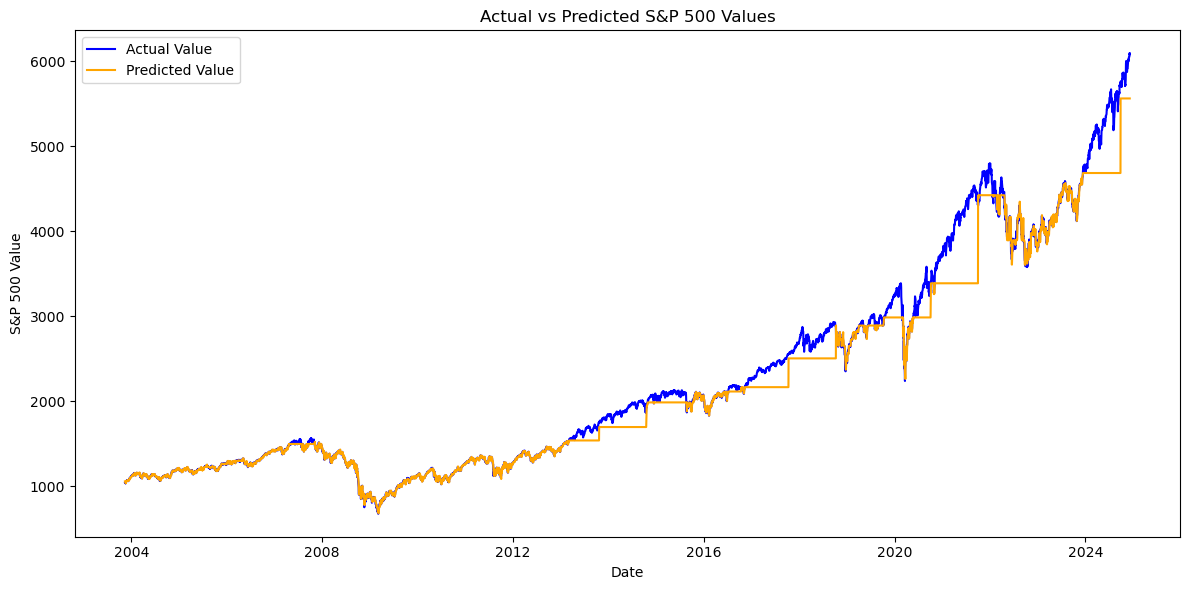

In [ ]:
base_regression_model = RandomForestRegressor(n_estimators=100, min_samples_split=50, random_state=1)

def predict_regression(train, test, predictors, model):
    model.fit(train[predictors], train["Tomorrow"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predicted Value")
    combined = pd.concat([test["Tomorrow"], preds], axis=1)
    return combined

def backtest_regression(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict_regression(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

regression_predictions = backtest_regression(sp500, base_regression_model, base_predictors)

print("Regression Model Results:")
mae = mean_absolute_error(regression_predictions["Tomorrow"], regression_predictions["Predicted Value"])
print(f"Mean Absolute Error: {mae}")

def plot_regression_results(predictions):
    plt.figure(figsize=(12, 6))
    plt.plot(predictions.index, predictions["Tomorrow"], label="Actual Value", color="blue")
    plt.plot(predictions.index, predictions["Predicted Value"], label="Predicted Value", color="orange")
    plt.title("Actual vs Predicted S&P 500 Values")
    plt.xlabel("Date")
    plt.ylabel("S&P 500 Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_regression_results(regression_predictions)
